In [418]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

## Load in Data

In [419]:
path = '/Users/delphineloke/Desktop/DSA4262_Health5/data/Radiology-manual-annotations.xlsx'
clinical_all = pd.read_excel(path, sheet_name='all')
clinical_mass = pd.read_excel(path, sheet_name='mass_description')
clinical_distortion = pd.read_excel(path, sheet_name='distortion')
clinical_postop = pd.read_excel(path, sheet_name='postoperative')
clinical_asymmetry = pd.read_excel(path, sheet_name='asymmetry')
clinical_calcifications = pd.read_excel(path, sheet_name='calcifications')
clinical_mass_enhancement = pd.read_excel(path, sheet_name='mass enhancement_description')
clinical_nonmass_enhancement = pd.read_excel(path, sheet_name='nonmass enhancement_description')
print(clinical_all.info())
print(f'Shape: {clinical_all.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Image_name                           2006 non-null   object
 1   Patient_ID                           2006 non-null   int64 
 2   Side                                 2006 non-null   object
 3   Type                                 2006 non-null   object
 4   Age                                  2006 non-null   int64 
 5   Breast density (ACR)                 2006 non-null   object
 6   BIRADS                               2006 non-null   object
 7   Findings                             2006 non-null   object
 8   View                                 2006 non-null   object
 9   Tags                                 2006 non-null   object
 10  Machine                              2006 non-null   int64 
 11  Pathology Classification/ Follow up  2006 n

## Data Preprocessing

### BIRADS Score

We notice that some patients have two BIRADS score and we choose to take the higher BIRADS score. Since the BIRAD scale indicates the likelihood of malignancy, we see that higher values correlated with a higher risk of cancer. Using the maximum ensures we don’t underestimate this risk.

In [420]:
clinical_all['BIRADS'].value_counts()

BIRADS
1        801
5        340
2        325
4        295
3        156
3$2       31
4$2       21
5$2       18
6          8
4$3        3
3$2$2      2
2$4        2
2$2        2
2$3        2
Name: count, dtype: int64

In [421]:
print(f'Initial BIRADS score count: {clinical_all['BIRADS'].value_counts()}')
clinical_all['BIRADS'] = clinical_all['BIRADS'].astype(str).apply(lambda x: max(map(int, x.split('$'))) if '$' in x else int(x))
print(f'Final BIRADS score count: {clinical_all['BIRADS'].value_counts()}')


Initial BIRADS score count: BIRADS
1        801
5        340
2        325
4        295
3        156
3$2       31
4$2       21
5$2       18
6          8
4$3        3
3$2$2      2
2$4        2
2$2        2
2$3        2
Name: count, dtype: int64
Final BIRADS score count: BIRADS
1    801
5    358
2    327
4    321
3    191
6      8
Name: count, dtype: int64


### Breast Density (ACR)

More than half of the data had missing Breast Density (ACR) values. Since most patients had at least one ACR score, we used this score for the rest of their rows. However, for those with no ACR score at all, we decided to impute the data using KNN. The ACR scores were first converted to a numerical value and we selected key relevant features (Age and BIRADS score) before applying the KNN imputer to predict missing ACR scores based on similar patients.

In [422]:
clinical_all['Breast density (ACR)'].value_counts()

Breast density (ACR)
_    1082
C     517
B     329
D      70
A       8
Name: count, dtype: int64

In [423]:
# Propagating existing ACR scores for patients with existing data
clinical_all['Breast density (ACR)'] = clinical_all['Breast density (ACR)'].replace('_', np.nan)

print(f'Intial Breast Density (ACR) counts: {clinical_all['Breast density (ACR)'].value_counts()}')

# Fill missing ACR values with the existing value for each Patient_ID
clinical_all['Breast density (ACR)'] = clinical_all.groupby('Patient_ID')['Breast density (ACR)'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

print(f'Final Breast Density (ACR) count: {clinical_all['Breast density (ACR)'].value_counts()}')

# Number of missing ACR scores
print(f'Number of missing ACR scores: {clinical_all[clinical_all['Breast density (ACR)'].isna() == True].shape[0]}')

Intial Breast Density (ACR) counts: Breast density (ACR)
C    517
B    329
D     70
A      8
Name: count, dtype: int64
Final Breast Density (ACR) count: Breast density (ACR)
C    1092
B     712
D     144
A      16
Name: count, dtype: int64
Number of missing ACR scores: 42


/var/folders/gd/v8v96pt94wl6b52w5qldf23m0000gn/T/ipykernel_81298/1898321574.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  clinical_all['Breast density (ACR)'] = clinical_all.groupby('Patient_ID')['Breast density (ACR)'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
/var/folders/gd/v8v96pt94wl6b52w5qldf23m0000gn/T/ipykernel_81298/1898321574.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinical_all['Breast density (ACR)'] = clinical_all.groupby('Patient_ID')['Breast density (ACR)'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [424]:

print(f'Intial Breast Density (ACR) counts: {clinical_all['Breast density (ACR)'].value_counts()}')
acr_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
clinical_all['Breast density (ACR)'] = clinical_all['Breast density (ACR)'].map(acr_mapping)

# Select relevant numerical columns for KNN Imputation
features = ['Age', 'BIRADS', 'Breast density (ACR)']
df_impute = clinical_all[features]

# Convert BIRADS to numeric (handle '3$2' cases)
df_impute['BIRADS'] = df_impute['BIRADS'].astype(str).apply(lambda x: max(map(int, x.split('$'))) if '$' in x else int(x))

# Initialize KNN Imputer (using k=5)
imputer = KNNImputer(n_neighbors=5)
df_impute_filled = pd.DataFrame(imputer.fit_transform(df_impute), columns=features)

# Map ACR values back to categorical labels
acr_reverse_mapping = {1: 'A', 2: 'B', 3: 'C', 4: 'D'}
df_impute_filled['Breast density (ACR)'] = df_impute_filled['Breast density (ACR)'].round().map(acr_reverse_mapping)
clinical_all['Breast density (ACR)'] = df_impute_filled['Breast density (ACR)']

print(f'Final Breast Density (ACR) count: {clinical_all['Breast density (ACR)'].value_counts()}')

# Number of missing ACR scores
print(f'Number of missing ACR scores: {clinical_all[clinical_all['Breast density (ACR)'].isna() == True].shape[0]}')

Intial Breast Density (ACR) counts: Breast density (ACR)
C    1092
B     712
D     144
A      16
Name: count, dtype: int64
Final Breast Density (ACR) count: Breast density (ACR)
C    1113
B     732
D     145
A      16
Name: count, dtype: int64
Number of missing ACR scores: 0


/var/folders/gd/v8v96pt94wl6b52w5qldf23m0000gn/T/ipykernel_81298/1881868350.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_impute['BIRADS'] = df_impute['BIRADS'].astype(str).apply(lambda x: max(map(int, x.split('$'))) if '$' in x else int(x))


### Merging with other sheets

In [425]:
clinical_df = clinical_all.copy()

sheet_dict = {
    'Distortion': clinical_distortion,
    'Postoperative': clinical_postop,
    'Asymmetry': clinical_asymmetry,
    'Calcifications': clinical_calcifications,
    'Nonmass': clinical_nonmass_enhancement,
    'Mass': clinical_mass,
    'Mass enhancement': clinical_mass_enhancement
}

for key, value in sheet_dict.items():
    clinical_df[key] = clinical_df.set_index(['Patient_ID', 'Type', 'Side', 'View']).index.isin(
        value.set_index(['Patient_ID', 'Type', 'Side', 'View']).index
    ).astype(int)

    print(clinical_df[key].value_counts())

print(f'clinical_df shape: {clinical_df.shape}')

Distortion
0    1956
1      50
Name: count, dtype: int64
Postoperative
0    1847
1     159
Name: count, dtype: int64
Asymmetry
0    1775
1     231
Name: count, dtype: int64
Calcifications
0    1766
1     240
Name: count, dtype: int64
Nonmass
0    1823
1     183
Name: count, dtype: int64
Mass
0    1696
1     310
Name: count, dtype: int64
Mass enhancement
0    1672
1     334
Name: count, dtype: int64
clinical_df shape: (2006, 19)


In [426]:
# Standardizing input values using mapping dictionaries
mass_shape_map = {
    '_': np.nan, 'Round-Oval': 'Round - Oval', 'Oval - Round': 'Round - Oval', 'Oval- Rounded': 'Round - Oval',
    'Irregular ': 'Irregular', 'Round- Irregular ': 'Irregular - Round', 'Oval ': 'Oval', 'Round ': 'Round',
    'Irregular-Oval': 'Irregular - Oval'
}
mass_margin_map = {
    'Speculated ': 'Speculated', 'Indistinct ': 'Indistinct', 'Circumscribed-Obscured': 'Circumscribed - Obscured',
    'Circumscribed- Obscured': 'Circumscribed - Obscured', 'Speculated-Circumscribed': 'Speculated - Circumscribed',
    'Partially obscured lobulated': 'Lobulated - Partially Obscured', 'Lobulated partially obscured': 'Lobulated - Partially Obscured',
    'Partially obscured  ': 'Partially obscured', 'Speculated ulcerating': 'Speculated - Ulcerating', 'Irregular ': 'Irregular',
}
density_enhancement_map = {
    'High ': 'High', 'Equal ': 'Equal', 'High-Equal': 'High - Equal', '_': np.nan,
    'Mixed ': 'Equal', 'Mixed equal and low ': 'Equal', 'High- Overlying microcalcifications': 'High with overlying microcalcification',
    'Equal- Overlying calcifications': 'Equal with overlying macrocalcification'
}

enhancement_pattern_map = {
    "Heterogenous - Non enhancement": "Heterogenous",
    "Heterogenous - Rim": "Heterogenous",
    "Regular rim enhancement": "Rim Enhancement",
    "Irregular rim enhancement": "Rim Enhancement",
    "Enhancing mass with dark internal septations": "Enhancing mass",
    "Focus enhancement": "Focal enhancement",
    "Stippled enhancement": "Stippled",
    "Ring - Homogenous": "Ring Enhancement",
    "Faint focal enhancement": "Faint Enhancement",
    "Faint": "Faint Enhancement",
    "Flap": "Other",
    "Partial rim": "Other",
    "IMLN": "IMLN",
    "Rim": "Rim Enhancement",
    "Non enhancement": "Non Enhancement"
}

# standardising clinical_mass
clinical_mass['Mass shape'] = clinical_mass['Mass shape'].replace(mass_shape_map)
clinical_mass['Mass margin'] = clinical_mass['Mass margin'].replace(mass_margin_map)
clinical_mass['Mass density/enhancement pattern'] = clinical_mass['Mass density/enhancement pattern'].replace(density_enhancement_map)

clinical_mass_enhancement['Mass shape'] = clinical_mass_enhancement['Mass shape'].replace(mass_shape_map)
clinical_mass_enhancement['Mass margin'] = clinical_mass_enhancement['Mass margin'].replace(mass_margin_map)
clinical_mass_enhancement['Mass density/enhancement pattern'] = clinical_mass_enhancement['Mass density/enhancement pattern'].replace(density_enhancement_map)

# clinical_mass contains one entry which does not hold any information about the mass. We choose to remove this entry as it could be a mislabeled patient and could affect results.
clinical_mass.replace('_', np.nan, inplace=True)
clinical_mass_enhancement.replace('_', np.nan, inplace=True)
clinical_mass.dropna(subset=['Single/Multiple', 'Mass density/enhancement pattern', 'Mass shape', 'Mass margin'], 
                     how='all', inplace=True)

# Replace values in the column
clinical_mass_enhancement['Mass density/enhancement pattern'] = (
    clinical_mass_enhancement['Mass density/enhancement pattern']
    .replace(enhancement_pattern_map)
)

# Handle very rare categories (e.g., those with <3 occurrences)
threshold = 3
counts = clinical_mass_enhancement['Mass density/enhancement pattern'].value_counts()
rare_categories = counts[counts < threshold].index.tolist()
clinical_mass_enhancement['Mass density/enhancement pattern'] = (
    clinical_mass_enhancement['Mass density/enhancement pattern']
    .apply(lambda x: "Other" if x in rare_categories else x)
)

# Remove leading/trailing spaces (if any)
clinical_mass_enhancement['Mass density/enhancement pattern'] = (
    clinical_mass_enhancement['Mass density/enhancement pattern'].str.strip()
)



In [427]:
# Create new columns, merging based on clinical_mass and clinical_mass_enhancement dataframes
# clinical_mass is only for 'DM' (low-energy) images while clinical_mass_enhancement is for 'CESM' (subtracted) images

# merging clinical_mass
clinical_mass_selected = clinical_mass[['Patient_ID', 'Side', 'Type', 'View', 'Single/Multiple', 'Mass density/enhancement pattern', 'Mass shape', 'Mass margin']]
clinical_df = clinical_df.merge(clinical_mass_selected, on=['Patient_ID', 'Type', 'Side', 'View'], how='left')

clinical_df.columns = ['Image_name', 'Patient_ID', 'Side', 'Type', 'Age',
       'Breast density (ACR)', 'BIRADS', 'Findings', 'View', 'Tags', 'Machine',
       'Pathology Classification/ Follow up', 'Distortion', 'Postoperative',
       'Asymmetry', 'Calcifications', 'Nonmass', 'Mass', 'Mass enhancement',
       'Single/Multiple (Mass)', 'Mass density', 'Mass shape',
       'Mass margin']

# merging clinical_mass_enhancement
clinical_mass_enhancement_selected = clinical_mass_enhancement[['Patient_ID', 'Side', 'Type', 'View', 'Single/Multiple', 'Mass density/enhancement pattern', 'Mass shape', 'Mass margin']]
clinical_df = clinical_df.merge(clinical_mass_enhancement_selected, on=['Patient_ID', 'Type', 'Side', 'View'], how='left')

clinical_df.columns = ['Image_name', 'Patient_ID', 'Side', 'Type', 'Age',
       'Breast density (ACR)', 'BIRADS', 'Findings', 'View', 'Tags', 'Machine',
       'Pathology Classification/ Follow up', 'Distortion', 'Postoperative',
       'Asymmetry', 'Calcifications', 'Nonmass', 'Mass', 'Mass enhancement',
       'Single/Multiple (Mass)', 'Mass density', 'Mass shape',
       'Mass margin', 'Single/Multiple (Mass enhancement)', 'Enhancement pattern',
       'Mass enhancement shape', 'Mass enhancement margin']

print(clinical_df.shape)

(2006, 27)


In [428]:
patients_df = clinical_df.groupby(['Patient_ID', 'Side']).agg({
    'Age': 'first',  
    'Breast density (ACR)': 'first',  
    'BIRADS': 'max', 
    'Pathology Classification/ Follow up': lambda x: ', '.join(set(x)) 
}).reset_index()
patients_df.loc[patients_df['Pathology Classification/ Follow up'] == 'Normal, Benign', 'Pathology Classification/ Follow up'] = 'Benign, Normal'

print(patients_df)

     Patient_ID Side  Age Breast density (ACR)  BIRADS  \
0             1    L   46                    C       4   
1             2    L   31                    C       2   
2             2    R   31                    C       3   
3             3    L   45                    C       5   
4             3    R   45                    C       2   
..          ...  ...  ...                  ...     ...   
561         324    R   25                    C       3   
562         325    L   49                    B       1   
563         325    R   49                    B       3   
564         326    L   51                    C       4   
565         326    R   51                    C       2   

    Pathology Classification/ Follow up  
0                             Malignant  
1                                Benign  
2                                Benign  
3                             Malignant  
4                                Benign  
..                                  ...  
561      

In [429]:
clinical_df.to_csv('/Users/delphineloke/Desktop/DSA4262_Health5/data/clinical_data.csv', index=False)

## EDA

In [430]:
clinical_data = pd.read_csv('/data/clinical_data.csv')
clinical_data.head()

,Image_name,Patient_ID,Side,Type,Age,Breast density (ACR),BIRADS,Findings,View,Tags,...,Mass,Mass enhancement,Single/Multiple (Mass),Mass density,Mass shape,Mass margin,Single/Multiple (Mass enhancement),Enhancement pattern,Mass enhancement shape,Mass enhancement margin
0,P1_L_DM_MLO,1,L,DM,46,C,4,Architectural distortion,MLO,"suspicious, distortion",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P1_L_CM_MLO,1,L,CESM,46,C,4,Heterogenous non mass enhancement,MLO,"suspicious, non mass",...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P2_R_DM_CC,2,R,DM,31,C,3,Multiple equal density masses$Benign macrocal...,CC,"benign, masses, macrocalcification",...,1,0,Multiple,Equal,Round - Oval,Circumscribed - Obscured,NaN,NaN,NaN,NaN
3,P2_R_DM_MLO,2,R,DM,31,C,3,Multiple equal density masses$Benign macrocalc...,MLO,"benign, masses, macrocalcification",...,1,0,Multiple,Equal,Round - Oval,Circumscribed - Obscured,NaN,NaN,NaN,NaN
4,P2_R_CM_CC,2,R,CESM,31,C,3,Multiple homogenously enhancing masses,CC,"benign, masses, homogenous",...,0,1,NaN,NaN,NaN,NaN,Multiple,Homogenous,Round - Oval,Circumscribed


### Breast Side

A quick analysis using a bar chart reveals that women tend to check their left breasts slightly more frequently than their right breasts. This observation aligns with broader medical statistics, which show that it is indeed more common for breast cancer to develop in the left breast.

https://www.nature.com/articles/s41598-022-16749-4

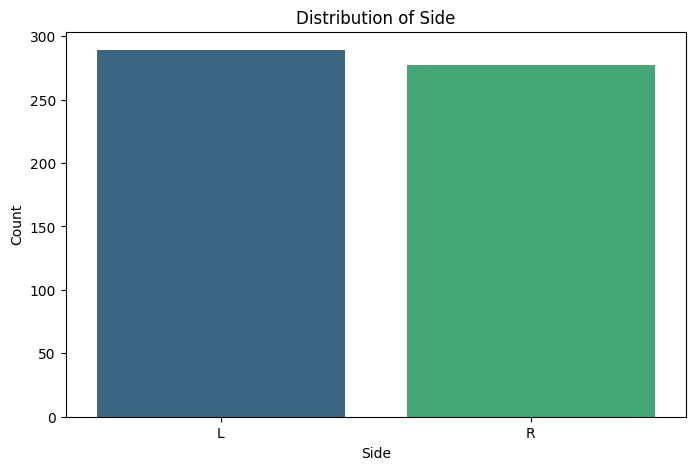

In [431]:
plt.figure(figsize=(8, 5))
sns.countplot(x=patients_df['Side'], palette="viridis", hue=patients_df['Side'], legend=False)
plt.xlabel("Side")
plt.ylabel("Count")
plt.title("Distribution of Side")
plt.show()

### Age
We see that the histogram shows a normal distribution, indicating that the dataset generally has a good mix of ages. Additionally, we see that the mean age is around the age of 50 years old, aligning with known research that breast cancer risk increases with age, especially for individuals above 40. Since most patients are 50 or older, this dataset likely focuses on a higher-risk population rather than general screening.

https://www.komen.org/breast-cancer/risk-factor/age/

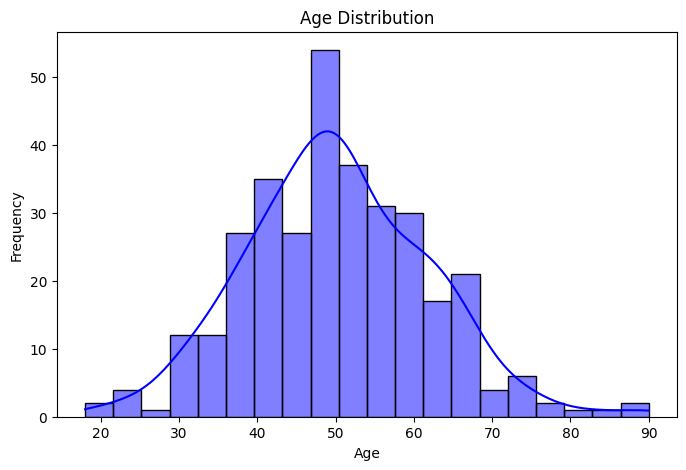

count    326.000000
mean      50.211656
std       11.660637
min       18.000000
25%       43.000000
50%       50.000000
75%       58.000000
max       90.000000
Name: Age, dtype: float64


In [432]:
age_df = patients_df.groupby('Patient_ID').agg({'Age': 'first'}).reset_index()
plt.figure(figsize=(8, 5))
sns.histplot(age_df['Age'], bins=20, kde=True, color='blue')
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution")
plt.show()
print(age_df['Age'].describe())

### Breast Density (ACR)

After imputing missing values, the majority of patients have ACR categories C and B.
Category B (Scattered areas of fibroglandular density): Small masses are generally easier to detect.
Category C (Heterogeneously dense): Makes it harder to spot small masses because dense tissue and tumors both appear white on mammograms.

Since dense breasts can obscure cancer detection, this could impact radiologists’ ability to diagnose early-stage malignancies. It may also mean the dataset contains more difficult cases requiring additional imaging (e.g., ultrasound or MRI).

https://www.cancer.org/cancer/types/breast-cancer/screening-tests-and-early-detection/mammograms/breast-density-and-your-mammogram-report.html#:~:text=Category%20A%3A%20Breasts%20are%20almost,(described%20as%20heterogeneously%20dense).

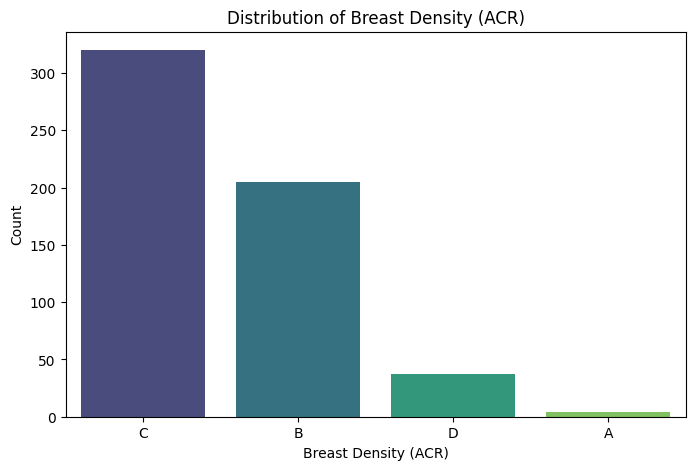

In [433]:
plt.figure(figsize=(8, 5))
sns.countplot(x=patients_df['Breast density (ACR)'], palette="viridis", hue=patients_df['Breast density (ACR)'], legend=False)
plt.xlabel("BIRADS Score")
plt.xlabel("Breast Density (ACR)")
plt.ylabel("Count")
plt.title("Distribution of Breast Density (ACR)")
plt.show()

### BIRADS Score

The ranking of BIRADS scores follows an interesting trend as it alternates between normal and suspicious findings.
We se that the most common BIRADS score is 1, indicating that there was no significant abnormality found on the images followed by a BIRADS score of 5 which highly suggest malignancy (the presence of cancer cells). 
The least common BIRADS score is 6 which is indicative of known cancer cases.

https://my.clevelandclinic.org/health/articles/bi-rads-breast-imaging-reporting-and-data-system

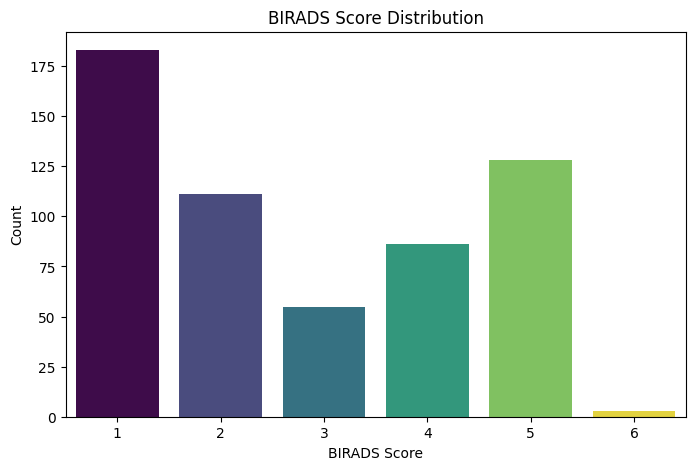

In [434]:
plt.figure(figsize=(8, 5))
sns.countplot(x=patients_df['BIRADS'], palette="viridis", hue=patients_df['BIRADS'], legend=False)
plt.xlabel("BIRADS Score")
plt.ylabel("Count")
plt.title("BIRADS Score Distribution")
plt.show()


### Age vs BIRADS Score

A weak positive correlation is observed between age and BIRADS score, indicating that older patients tend to have higher-risk findings (though the relationship is not very strong). Hence, while age may contribute to malignancy risk, other factors (e.g., breast density, genetics, etc.) likely also play an effective role in determining the BIRADS score.

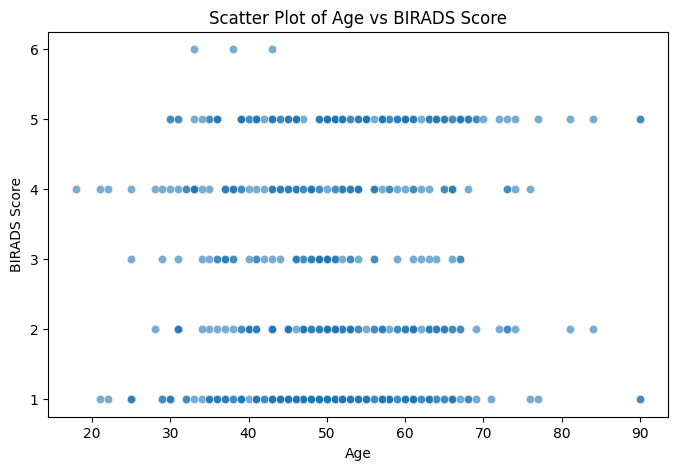

In [435]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=patients_df['Age'], y=patients_df['BIRADS'], alpha=0.6)
plt.xlabel("Age")
plt.ylabel("BIRADS Score")
plt.title("Scatter Plot of Age vs BIRADS Score")
plt.show()


### Abnormalities

A bar plot analyzing the count of abnormalities across patients reveals an interesting distribution pattern. The majority of patients do not exhibit any abnormalities, with the counts for "no abnormalities" significantly outweighing those with abnormalities. This suggests that the overall population in the dataset has a relatively low prevalence of notable abnormalities, which could be consistent with typical screening or patient cohorts where abnormalities are not overly common.

However, for the patients who do present with abnormalities, the plot indicates that enhanced masses and masses are the most frequent types of abnormalities observed. This suggests that when abnormalities do appear, they are predominantly characterized by masses—either with or without enhancement—which are often considered clinically significant findings.

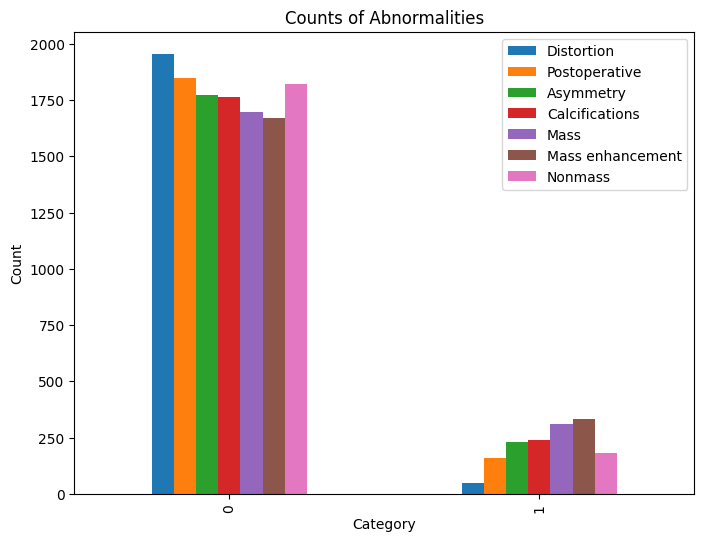

In [436]:
distortion_counts = clinical_data['Distortion'].value_counts()
postoperative_counts = clinical_data['Postoperative'].value_counts()
asymmetry_counts = clinical_data['Asymmetry'].value_counts()
calcifications_counts = clinical_data['Calcifications'].value_counts()
mass_counts = clinical_data['Mass'].value_counts()
mass_enhancement_counts = clinical_data['Mass enhancement'].value_counts()
nonmass_counts = clinical_data['Nonmass'].value_counts()

combined_counts = pd.DataFrame({
    'Distortion': distortion_counts,
    'Postoperative': postoperative_counts,
    'Asymmetry': asymmetry_counts,
    'Calcifications': calcifications_counts,
    'Mass': mass_counts,
    'Mass enhancement': mass_enhancement_counts,
    'Nonmass': nonmass_counts
}).fillna(0).astype(int)

combined_counts.plot(kind='bar', figsize=(8, 6))
plt.title('Counts of Abnormalities')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

### Pathology Classification/ Follow up

The Pathology Classification/Follow-up bar chart reveals that the majority of patients are classified as Normal, with a significant portion diagnosed with Malignant abnormalities, followed by Benign conditions. A smaller group falls under Benign, Normal, indicating patients with benign abnormalities that are otherwise normal, while the least common category is Malignant, Normal, which suggests early-stage or less detectable cancers in otherwise normal patients. This distribution emphasizes the importance of regular screening and follow-up, especially for those with malignant or benign conditions, and highlights the complexity of diagnoses, as some patients may exhibit mixed classifications requiring ongoing monitoring.

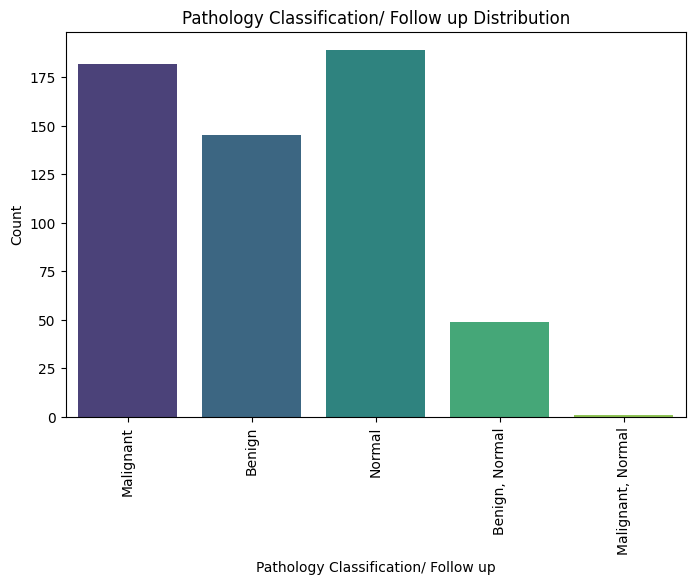

In [437]:
plt.figure(figsize=(8, 5))
sns.countplot(x=patients_df['Pathology Classification/ Follow up'], palette="viridis", hue=patients_df['Pathology Classification/ Follow up'], legend=False)
plt.xlabel("Pathology Classification/ Follow up")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Pathology Classification/ Follow up Distribution")
plt.show()

### Mass and Nonmass Analysis
The primary distinction between Mass and Mass Enhanced imaging lies in the type of imaging technique used. By comparing the distribution of characteristics in these two categories, we can evaluate the benefits that Mass Enhanced imaging provides.

### Mass Density
Majority of the mass densities are equal or high. This suggests that the masses observed in the data are relatively denser, which might indicate more prominent or well-defined masses. High-density masses can often be associated with certain tumor types or tissue types in medical imaging, but further context would be required to understand if this is indicative of malignancy or benign growth.

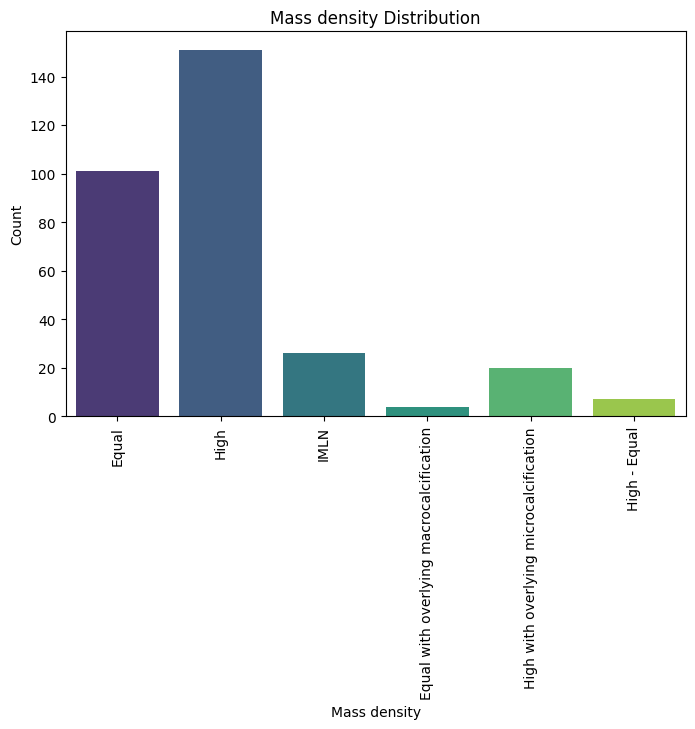

In [438]:
plt.figure(figsize=(8, 5))
sns.countplot(x=clinical_data['Mass density'], palette="viridis", hue=clinical_data['Mass density'], legend=False)
plt.xlabel("Mass density")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Mass density Distribution")
plt.show()


### Mass Enhancement Pattern
The enhancement pattern for masses is dominated by 'heterogeneous', followed by 'homogeneous'. Heterogeneous enhancement indicates that the mass shows varying levels of intensity, which can be characteristic of complex lesions or tumors, often suggesting a malignant or irregular nature. Homogeneous enhancement suggests more uniform characteristics, often seen in benign lesions like cysts.

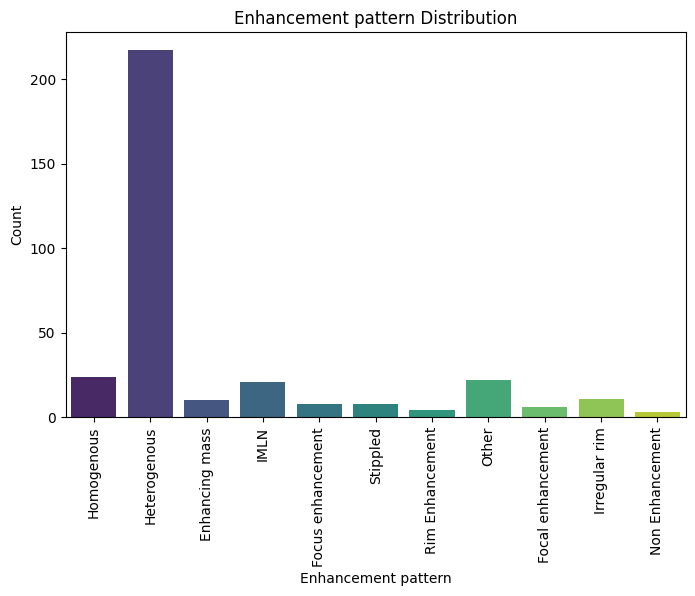

In [439]:
plt.figure(figsize=(8, 5))
sns.countplot(x=clinical_data['Enhancement pattern'], palette="viridis", hue=clinical_data['Enhancement pattern'], legend=False)
plt.xlabel("Enhancement pattern")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Enhancement pattern Distribution")
plt.show()

### Mass Enhancement Leading to 'Multiple' Masses:
Mass enhancement seems to correlate with a higher frequency of 'multiple' masses. The use of enhancement likely highlights multiple distinct lesions in the same region. This could reflect a trend where enhanced imaging allows better differentiation between multiple masses that might have been harder to discern in standard imaging.
the mass enhancement for single/multiple masses lead to an increase in 'multiple' mass. 

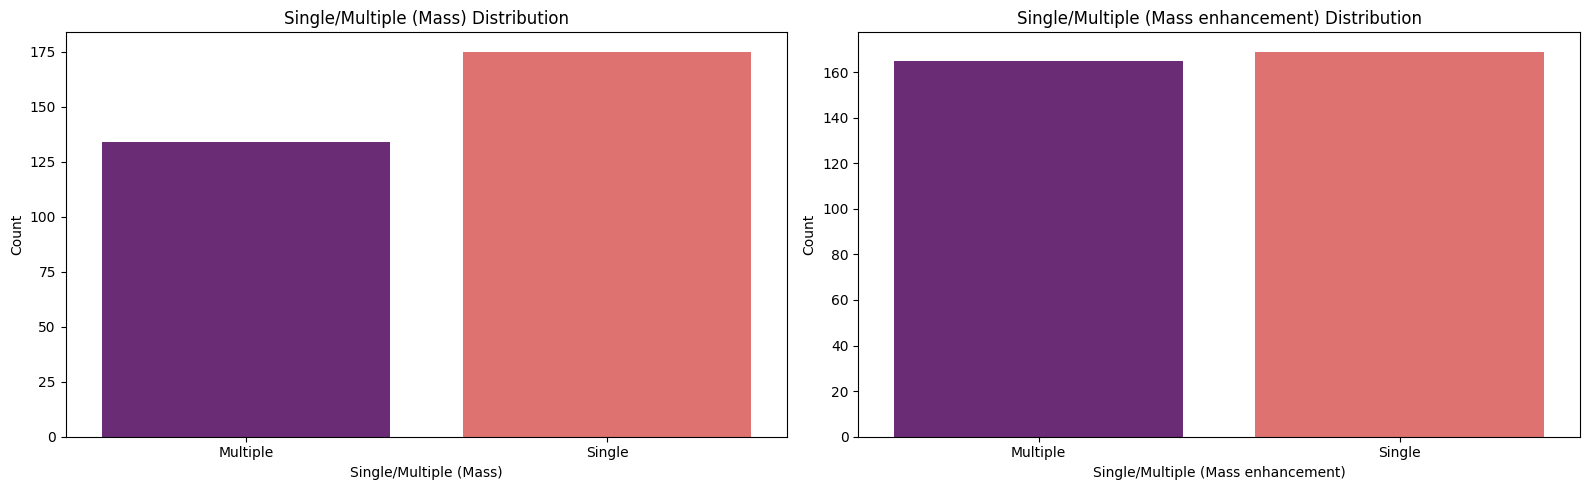

In [440]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.countplot(x=clinical_data['Single/Multiple (Mass)'], hue=clinical_data['Single/Multiple (Mass)'], palette="magma", ax=ax[0], legend=False)
ax[0].set_xlabel("Single/Multiple (Mass)")
ax[0].set_ylabel("Count")
ax[0].set_title("Single/Multiple (Mass) Distribution")

sns.countplot(x=clinical_data['Single/Multiple (Mass enhancement)'], hue=clinical_data['Single/Multiple (Mass enhancement)'], palette="magma", ax=ax[1], legend=False)
ax[1].set_xlabel("Single/Multiple (Mass enhancement)")
ax[1].set_ylabel("Count")
ax[1].set_title("Single/Multiple (Mass enhancement) Distribution")

plt.tight_layout() 
plt.show()


### Mass Shape
For mass shapes, enhancement significantly narrows down the possible shapes. The initial broad categories in mass shape, such as 'Round-Oval', 'Irregular', and other hybrid shapes, are narrowed down to a more concise set: 'Round-Oval', 'Irregular', 'Oval', 'Round', and other variants. Enhanced imaging is likely providing clearer boundaries, leading to a reduced set of potential mass shapes, which might help in more accurately categorizing the nature of the mass.

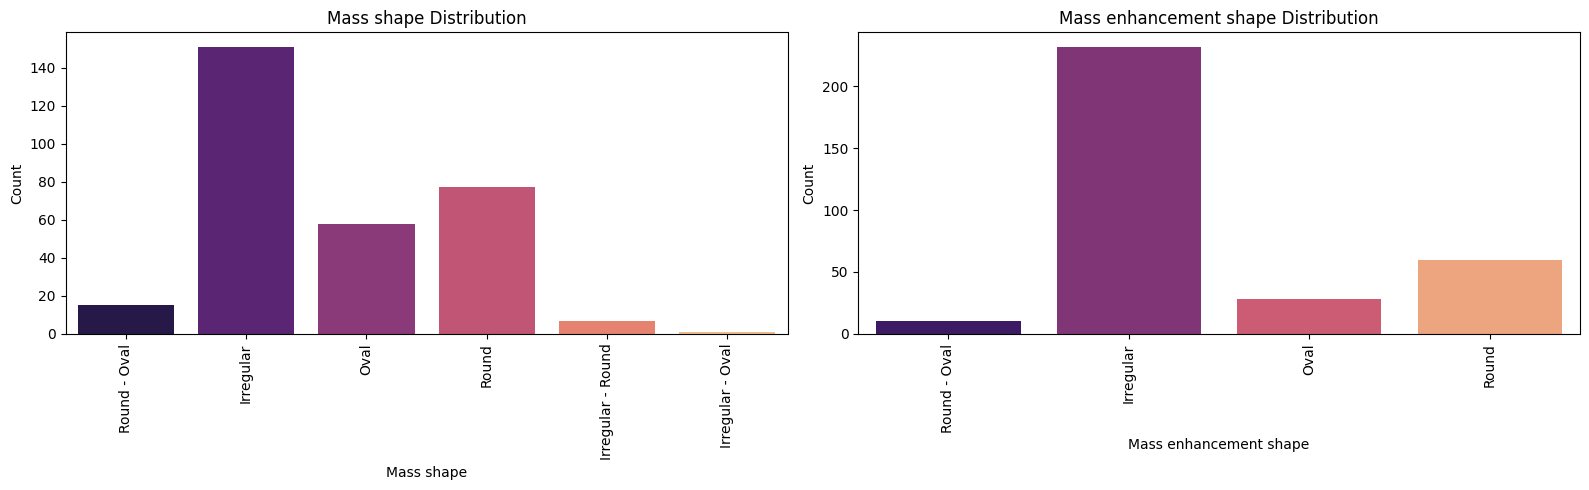

In [441]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.countplot(x=clinical_data['Mass shape'], hue=clinical_data['Mass shape'], palette="magma", ax=ax[0], legend=False)
ax[0].set_xlabel("Mass shape", )
ax[0].set_ylabel("Count")
ax[0].set_title("Mass shape Distribution")
ax[0].tick_params(axis='x', rotation=90)

sns.countplot(x=clinical_data['Mass enhancement shape'], hue=clinical_data['Mass enhancement shape'], palette="magma", ax=ax[1], legend=False)
ax[1].set_xlabel("Mass enhancement shape")
ax[1].set_ylabel("Count")
ax[1].set_title("Mass enhancement shape Distribution")
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()  
plt.show()


### Mass Margin
Mass margin groupings show a similar pattern, narrowing down from a wide range of categories like 'Circumscribed-Obscured', 'Speculated', 'Indistinct', etc., to a smaller set such as 'Circumscribed', 'Speculated', 'Irregular', and 'Lobulated circumscribed'. The narrowing of margin categories may be due to the ability of enhanced imaging to better delineate the borders of the mass. The enhancement helps highlight subtle distinctions in margin characteristics that may indicate the growth pattern (benign or malignant).

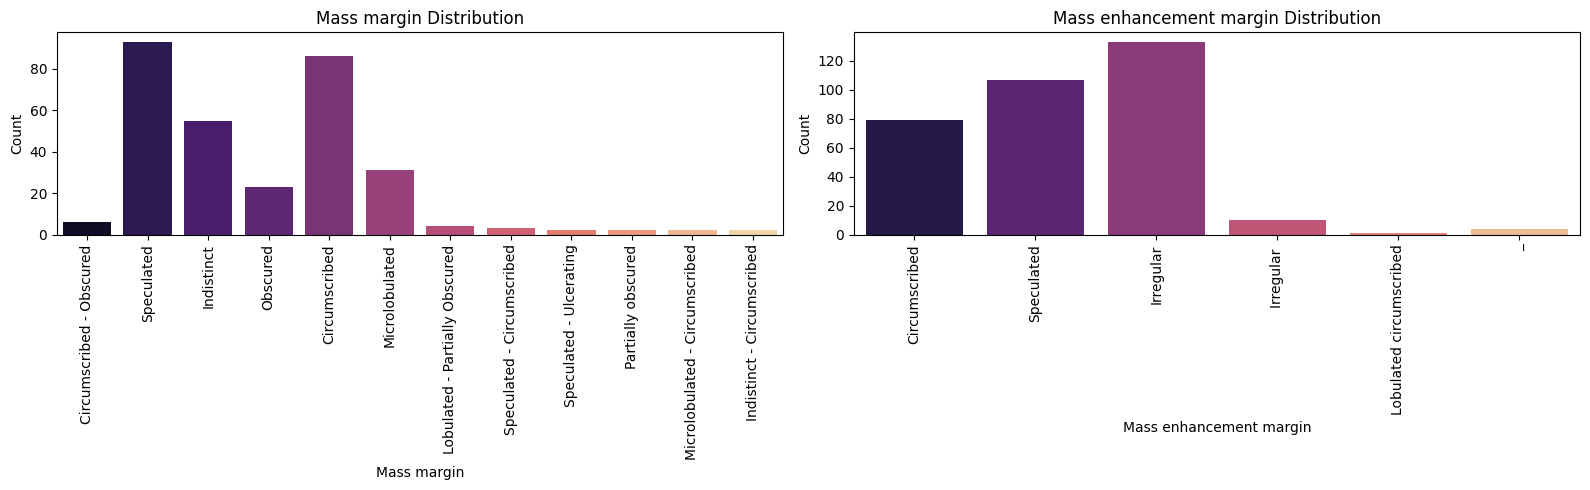

In [442]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.countplot(x=clinical_data['Mass margin'], hue=clinical_data['Mass margin'], palette="magma", ax=ax[0], legend=False)
ax[0].set_xlabel("Mass margin", )
ax[0].set_ylabel("Count")
ax[0].set_title("Mass margin Distribution")
ax[0].tick_params(axis='x', rotation=90)

sns.countplot(x=clinical_data['Mass enhancement margin'], hue=clinical_data['Mass enhancement margin'], palette="magma", ax=ax[1], legend=False)
ax[1].set_xlabel("Mass enhancement margin")
ax[1].set_ylabel("Count")
ax[1].set_title("Mass enhancement margin Distribution")
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout() 
plt.show()
